In [2]:
from astropy.io import fits # to read in FITS files
from astropy.wcs import WCS # to read coordinates
from reproject import reproject_interp # to align images
import numpy as np # math applied to arrays (important, no need to read pixel for pixel!)
from matplotlib import pyplot as plt # plot library 
from astropy.visualization import ZScaleInterval # create minimum and maximum Z values for plotting 
import astropy.units as u
from astropy.coordinates import SkyCoord
import glob # finding pathnames
import os # os.path to manipulate file paths 
from scipy.stats import rankdata
import matplotlib.colors as mcolors
import matplotlib.cm as cm

region_size_define = 3


In [3]:
# Returns the header and data of a .fit file.
def get_data(data_im):
    hdu = fits.open(data_im)[0]
    header = hdu.header 
    data = hdu.data
    wcs = WCS(hdu.header)
    return header, data, wcs

# Aligns image with the reference coordinates.
def reproject_image(image_filename, wcs_ref):
    hdu = fits.open(image_filename)[0]
    array, footprint = reproject_interp(hdu, wcs_ref)
    return array

# Function to calculate distances from the center
def calc_distance(image, x_center, y_center):
    # Make a coordinate grid of the image
    y_indices, x_indices = np.indices(image.shape)
    # Calculate the distance from the chosen center
    distances = np.sqrt((x_indices - x_center) ** 2 + (y_indices - y_center) ** 2)
    return distances

# Calculate background noise
def calc_background(image, xmin, xmax, ymin, ymax):
    background_region = image[ymin:ymax, xmin:xmax]
    average = np.mean(background_region)
    return average

# Function to calculate the flux
def convert_to_magnitude(image, zero_point):
    # Add a min flux to avoid log(0)
    min_flux = 1e-10
    flux = -2.5 * np.log10(np.maximum(image,min_flux)/60) + zero_point
    return flux

# Calculates the color index
def calc_color_index(filter1, filter2):
    color_index = filter1 - filter2
    return color_index

# Divide the images into sections and calculate the average magnitude for each section
def section_image(image, region_size=(region_size_define, region_size_define)):
    y_len, x_len = image.shape
    x_sections = x_len // region_size[0]
    y_sections = y_len // region_size[1]
    averages = np.zeros((y_sections, x_sections))
    
    for i in range(y_sections):
        for j in range(x_sections):
            y_start = i * region_size[1]
            y_end = y_start + region_size[1]
            x_start = j * region_size[0]
            x_end = x_start + region_size[0]
            region = image[y_start:y_end, x_start:x_end]
            averages[i, j] = np.nanmean(region)
            
    return averages


In [4]:
# Change the data with whatever fit you're using.
# Easiest to 'copy relative path' if you're using the GitHub folder.
# Don't forget to change \ to /.
fit_g = "NGC_4449_g_stack_astrometry.fits"
fit_r = "NGC_4449_r_stack_astrometry.fits"
fit_L = 'NGC_4449_L_stack_astrometry.fits'
fit_ha = 'NGC_4449_ha_stack_astrometry.fits'

header_L, dat_L, wcs_L = get_data(fit_L)
header_g, dat_g, wcs_g = get_data(fit_g)
header_r, dat_r, wcs_r = get_data(fit_r)
header_ha, dat_ha, wcs_ha = get_data(fit_ha)


In [5]:
# Reference coordinates.
wcs_ref = WCS(header_g)

aligned_g = reproject_image(fit_g, wcs_ref)
print("Align g: done!")
aligned_r = reproject_image(fit_r, wcs_ref)
print("Align r: done!")
aligned_ha = reproject_image(fit_ha, wcs_ref)
print("Align h-alpha: done!")
aligned_L = reproject_image(fit_L, wcs_ref)
print("Align L: done!")


Align g: done!
Align r: done!
Align h-alpha: done!
Align L: done!


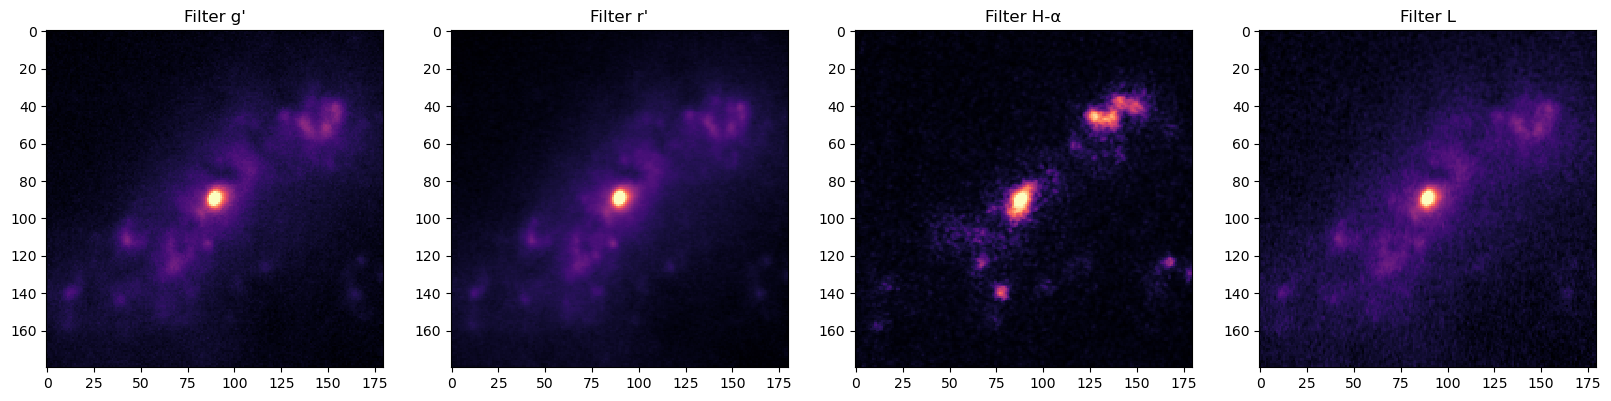

In [50]:
# Calculate distance from the center of each point
hdu = fits.open(fit_g)[0]
image_data = aligned_g
wcs = WCS(hdu.header)

# Define the ICRS coordinates of the galaxy center
ra_center = 187.046325  # Right Ascension in degrees
dec_center = 44.093558  # Declination in degrees

# Create a SkyCoord 
sky_coord = SkyCoord(ra=ra_center * u.deg, dec=dec_center * u.deg, frame='icrs')

# Convert WCS coordinates to pixel coordinates
x_center, y_center = wcs.world_to_pixel(sky_coord)

distances = calc_distance(image_data, x_center, y_center)

# x, y limits to crop images (1600, 2400, 1800, 2400 to see only NGC 4449)
x_min, x_max, y_min, y_max = 1900, 2080, 1970, 2150

# Crop the images
cropped_g= aligned_g[y_min:y_max, x_min:x_max]
cropped_r = aligned_r[y_min:y_max, x_min:x_max]
cropped_ha = aligned_ha[y_min:y_max, x_min:x_max]
cropped_L = aligned_L[y_min:y_max, x_min:x_max]
cropped_distances = distances[y_min:y_max, x_min:x_max]

# Visualize the cropped images
quantiles_g = np.percentile(cropped_g, (0.1, 99.9))
quantiles_r = np.percentile(cropped_r, (0.1, 99.9))
quantiles_ha = np.percentile(cropped_ha, (0.1, 99.9))
quantiles_L = np.percentile(cropped_L, (0.1, 99.9))
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
axs[0].imshow(cropped_g, cmap='magma', vmin = quantiles_g[0], vmax = quantiles_g[1], interpolation = 'nearest')
axs[0].set_title("Filter g'")
axs[1].imshow(cropped_r, cmap='magma', vmin = quantiles_r[0], vmax = quantiles_r[1], interpolation = 'nearest')
axs[1].set_title("Filter r'")
axs[2].imshow(cropped_ha, cmap='magma', vmin = quantiles_ha[0], vmax = quantiles_ha[1], interpolation = 'nearest')
axs[2].set_title("Filter H-α")
axs[3].imshow(cropped_L, cmap='magma', vmin = quantiles_L[0], vmax = quantiles_L[1], interpolation = 'nearest')
axs[3].set_title('Filter L')

plt.show()


In [51]:
xmin, xmax = 300, 450
ymin, ymax = 300, 400

bg_mean_L = calc_background(cropped_L, xmin, xmax, ymin, ymax)
bg_mean_ha = calc_background(cropped_ha, xmin, xmax, ymin, ymax)
bg_mean_r = calc_background(cropped_r, xmin, xmax, ymin, ymax)
bg_mean_g = calc_background(cropped_g, xmin, xmax, ymin, ymax)

no_bg_g = cropped_g - 244.13093010864273
no_bg_r = cropped_r - 332.6516227990238
no_bg_ha = cropped_ha - 1909.696413022794
no_bg_L = cropped_L - 1217.66174153108

# Remove hashtags to enable sigma clipping
def sigma_clip(image, sigma, maxiters):
    #clipped_data = astropy_sigma_clip(image, sigma=sigma, maxiters=maxiters, cenfunc='median', stdfunc='std')
    # Fill up masked points with NaN values
    #return clipped_data.filled(np.nan)
    return image

sigma = 5
maxiters = 5
clipped_ha = sigma_clip(no_bg_ha, sigma, maxiters)
clipped_g = sigma_clip(no_bg_g, sigma, maxiters)
clipped_L = sigma_clip(no_bg_L, sigma, maxiters)
clipped_r = sigma_clip(no_bg_r, sigma, maxiters)


c:\Users\juaop\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\juaop\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [52]:
zero_point = 25
magnitude_ha = convert_to_magnitude(clipped_ha, zero_point)
magnitude_L = convert_to_magnitude(clipped_L, zero_point)
magnitude_r = convert_to_magnitude(clipped_r, zero_point)
magnitude_g = convert_to_magnitude(clipped_g, zero_point)

color_index_g_min_r = calc_color_index(magnitude_g, magnitude_r)


In [53]:
# Calculate the average magnitudes for each section
sectioned_g = section_image(magnitude_g)
sectioned_r = section_image(magnitude_r)
sectioned_ha = section_image(magnitude_ha)
sectioned_L = section_image(magnitude_L)

# Calculate the color indices for the sections
sectioned_color_index_g_min_r = calc_color_index(sectioned_g, sectioned_r)
sectioned_color_index_ha_min_r = calc_color_index(sectioned_ha, sectioned_r)

# Flatten the sectioned arrays to use them for plotting
sectioned_color_index_flat = sectioned_color_index_g_min_r.flatten()
section_color_index_ha_min_r_flat = sectioned_color_index_ha_min_r.flatten()
sectioned_g_flat = sectioned_g.flatten()
sectioned_ha_flat = sectioned_ha.flatten()


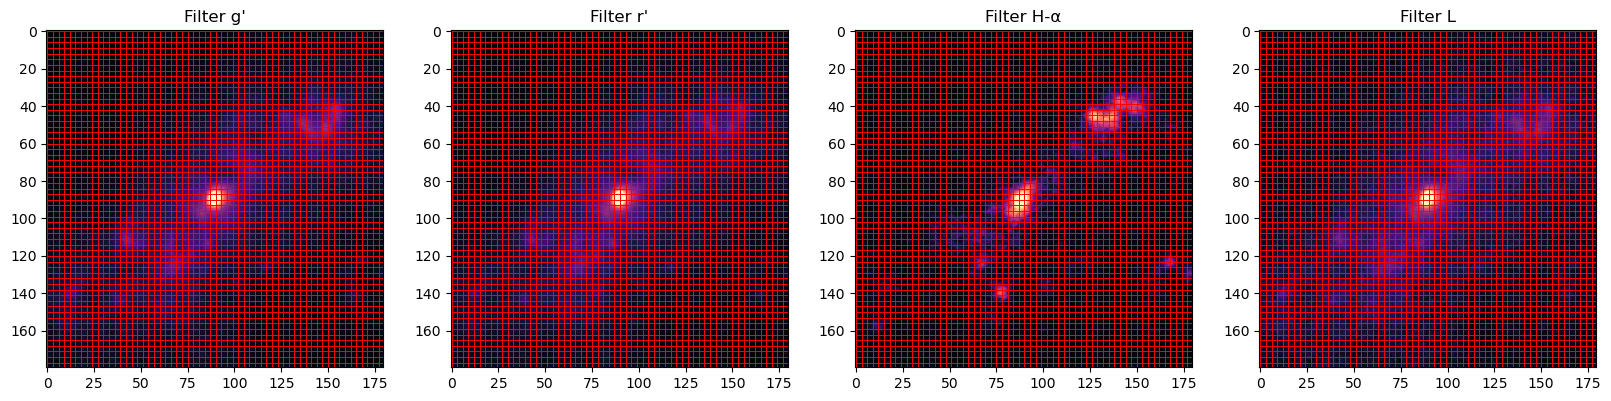

In [54]:
# Visualize the images with sections
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
y_len, x_len = cropped_g.shape

# Function to plot image with sections
def plot_with_sections(ax, image, title):
    ax.imshow(image, cmap='magma', vmin=np.percentile(image, 0.1), vmax=np.percentile(image, 99.9))
    for i in range(0, y_len, region_size_define):
        ax.axhline(i, color='red', linewidth=0.7)
    for j in range(0, x_len, region_size_define):
        ax.axvline(j, color='red', linewidth=0.7)
    ax.set_title(title)

# Plot each image with sections
plot_with_sections(axs[0], cropped_g, "Filter g'")
plot_with_sections(axs[1], cropped_r, "Filter r'")
plot_with_sections(axs[2], cropped_ha, "Filter H-α")
plot_with_sections(axs[3], cropped_L, "Filter L")

plt.show()




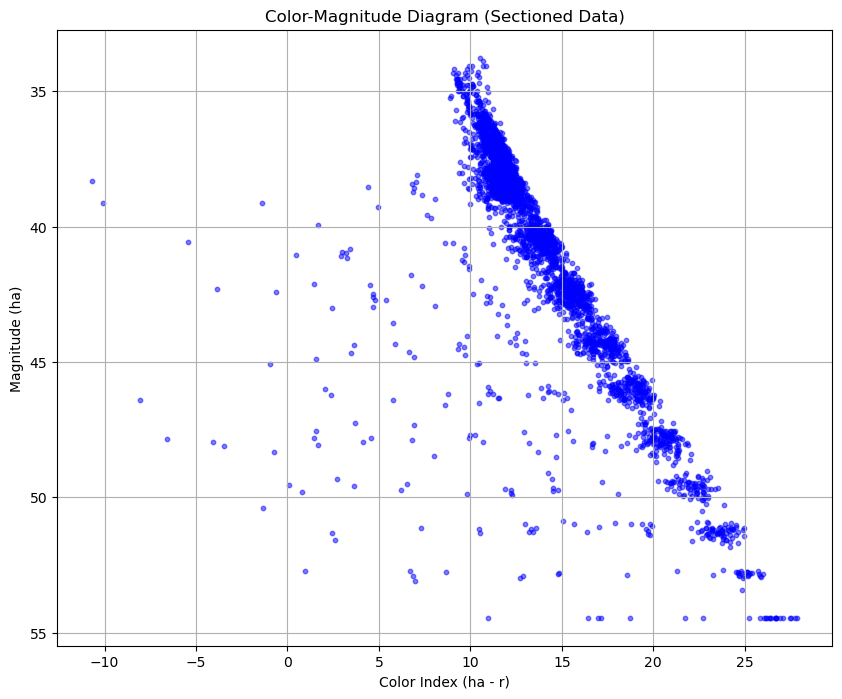

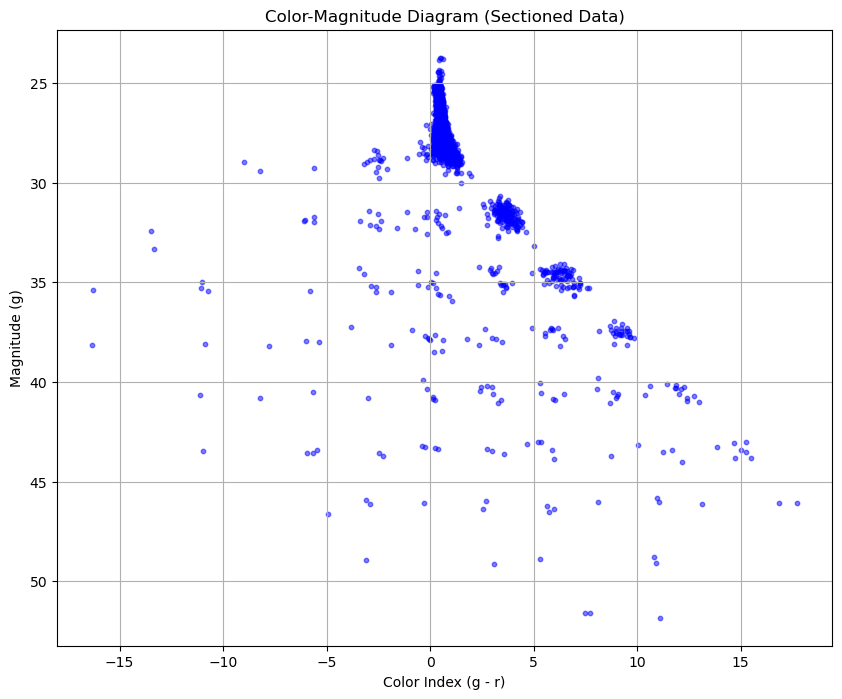

(60, 60)


In [55]:
# Plot the CMD with sectioned data
plt.figure(figsize=(10, 8))
plt.scatter(section_color_index_ha_min_r_flat, sectioned_ha_flat, c='blue', s=10, alpha=0.5)
plt.xlabel('Color Index (ha - r)')
plt.ylabel('Magnitude (ha)')
plt.title('Color-Magnitude Diagram (Sectioned Data)')
plt.gca().invert_yaxis()  # Invert y-axis for magnitudes
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 8))
plt.scatter(sectioned_color_index_flat, sectioned_g_flat, c='blue', s=10, alpha=0.5)
plt.xlabel('Color Index (g - r)')
plt.ylabel('Magnitude (g)')
plt.title('Color-Magnitude Diagram (Sectioned Data)')
plt.gca().invert_yaxis()  # Invert y-axis for magnitudes
plt.grid(True)
plt.show()

print(sectioned_color_index_ha_min_r.shape)


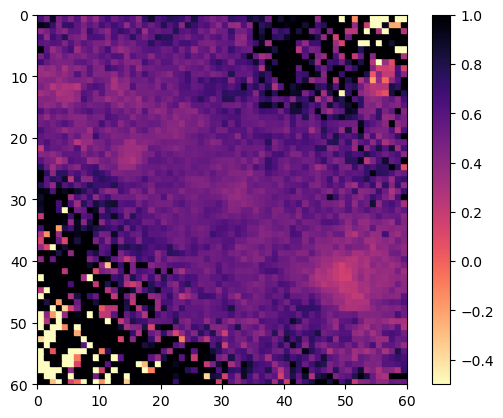

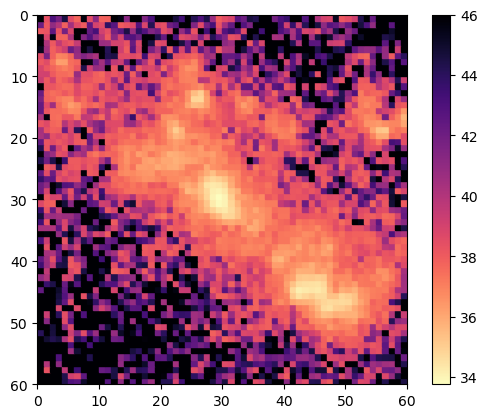

In [58]:
# Function to color cells based on average values
def plot_colored_grid(cell_averages, num_rows, num_cols, lower_cutoff, upper_cutoff):
    fig, ax = plt.subplots()
    cell_averages = np.array(cell_averages)
    
    # Apply cutoff
    cell_averages = np.clip(cell_averages, lower_cutoff, upper_cutoff)

    
    # Normalize cell averages to [0, 1] for colormap
    norm = mcolors.Normalize(vmin=np.min(cell_averages), vmax=np.max(cell_averages))
    cmap = plt.cm.magma.reversed()

    for i in range(num_rows):
        for j in range(num_cols):
            color = cmap(norm(cell_averages[i, j]))
            ax.add_patch(plt.Rectangle((j, num_rows - 1 - i), 1, 1, color=color))

    ax.set_xlim(0, num_cols)
    ax.set_ylim(0, num_rows)
    ax.set_aspect('equal')
    ax.invert_yaxis()
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)
    plt.show()
    
# Match the two numbers with the shape of the file
plot_colored_grid(sectioned_color_index_g_min_r, 60, 60, -0.5, 1)
plot_colored_grid(sectioned_ha, 60, 60, np.min(sectioned_ha), 46)